In [1]:
import torch
import torchvision
from torch.utils.data import dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.autograd import Variable
import numpy as np
import torch.optim as optim
import torch.optim.lr_scheduler
import time
import matplotlib.pyplot as plt
from torch import nn
import cv2
import torch.nn.functional as F
import os
image_size=96
use_gpu = torch.cuda.is_available()
batch_size=256
files=os.listdir("./faces/")
transform = transforms.Compose(
    [transforms.CenterCrop(96),transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5))])
trainset=torchvision.datasets.ImageFolder(root='./faces/', transform=transform)
data_loader = DataLoader(dataset=trainset,batch_size=batch_size)
seed_len=100

In [2]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.conv1=nn.ConvTranspose2d(seed_len,512,4,bias=False)#seed_len*1*1->48*4*4
        self.BatchNorm1=nn.BatchNorm2d(512)
        self.conv2=nn.ConvTranspose2d(512,256,4,stride=2,bias=False,padding=1)#48*4*4->24*8*8
        self.BatchNorm2=nn.BatchNorm2d(256)
        self.conv3=nn.ConvTranspose2d(256,128,4,stride=2,bias=False,padding=1)#24*8*8->12*16*16
        self.BatchNorm3=nn.BatchNorm2d(128)
        self.conv4=nn.ConvTranspose2d(128,64,4,stride=2,bias=False,padding=1)#12*16*16->6*32*32
        self.BatchNorm4=nn.BatchNorm2d(64)
        self.conv5=nn.ConvTranspose2d(64,3,5,stride=3,bias=False,padding=1)#6*32*32->3*64*64
        self.BatchNorm5=nn.BatchNorm2d(3)
        """torch.nn.ConvTranspose2d(in_channels, out_channels, 
                                 kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1)
        in_channels, out_channels, kernel_size
        """
        """
        self.conv1=nn.Conv2d(3,32,kernel_size=3,padding=1)#3*96*96->32*96*96
        self.conv2=nn.Conv2d(32,32,kernel_size=3,padding=1)#32*96*96->32*96*96
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3=nn.Conv2d(32,64,kernel_size=3,padding=1)#32*48*48->64*48*48
        self.conv4=nn.Conv2d(64,64,kernel_size=3,padding=1)#64*48*48->64*48*48
        #self.fc1=nn.Linear(64*96*96,16*96*96)
        self.fc1=nn.Linear(64*16*16,1000)
        self.fc2=nn.Linear(1000,3*64*64)"""
    def forward(self,x):
        x=self.conv1(x)
        x=self.BatchNorm1(x)
        x=F.relu(x,inplace=True)
        
        x=self.conv2(x)
        x=self.BatchNorm2(x)
        x=F.relu(x,inplace=True)
        
        x=self.conv3(x)
        x=self.BatchNorm3(x)
        x=F.relu(x,inplace=True)
        
        x=self.conv4(x)
        x=self.BatchNorm4(x)
        x=F.relu(x,inplace=True)
        
        x=F.tanh(self.conv5(x))
        return x
        """x=self.conv1(x)
        x=self.conv2(x)
        x=self.pool(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.pool(x)
        x=x.view(-1,64*16*16)
        x=F.tanh(self.fc1(x))
        x=F.tanh(self.fc2(x))
        return x.view((-1,3,64,64))"""

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.conv1=nn.Conv2d(3,64,kernel_size=5,padding=1,stride=3,bias=False)#3*96*96->32*96*96
        self.conv2=nn.Conv2d(64,128,kernel_size=4,padding=1,stride=2,bias=False)#32*96*96->32*96*96
        self.conv3=nn.Conv2d(128,256,kernel_size=4,padding=1,stride=2,bias=False)#32*96*96->32*96*96
        self.conv4=nn.Conv2d(256,512,kernel_size=4,padding=1,stride=2,bias=False)#32*96*96->32*96*96
        self.BatchNorm1=nn.BatchNorm2d(128)
        self.BatchNorm2=nn.BatchNorm2d(256)
        self.BatchNorm3=nn.BatchNorm2d(512)
        
        """self.conv3=nn.Conv2d(32,64,kernel_size=3,padding=1)#32*48*48->64*48*48
        self.conv4=nn.Conv2d(64,64,kernel_size=3,padding=1)#64*48*48->64*48*48
        
        self.conv5=nn.Conv2d(64,128,kernel_size=3,padding=1)#64*24*24->128*24*24
        self.conv6=nn.Conv2d(128,128,kernel_size=3,padding=1)#128*24*24->128*24*24
        
        self.conv7=nn.Conv2d(128,256,kernel_size=3,padding=1)#128*12*12->256*12*12
        self.conv8=nn.Conv2d(256,256,kernel_size=3,padding=1)#256*12*12->256*12*12
        
        self.conv9=nn.Conv2d(256,512,kernel_size=3,padding=1)#256*6*6->512*6*6
        self.conv10=nn.Conv2d(512,512,kernel_size=3,padding=1)#512*6*6->512*6*6
        """
        self.pool = nn.MaxPool2d(2, 2)
        self.conv5=nn.Conv2d(512,1,kernel_size=4)
        
        #self.fc2=nn.Linear(1000,50)
        #self.fc3=nn.Linear(50,2)
    def forward(self,x):
        x=self.conv1(x)
        x=F.leaky_relu(x,negative_slope=0.2,inplace=True)
        
        x=self.conv2(x)
#        print(x.shape)
        x=self.BatchNorm1(x)
        x=F.leaky_relu(x,negative_slope=0.2,inplace=True)
        
        x=self.conv3(x)
#        print(x.shape)
        x=self.BatchNorm2(x)
        x=F.leaky_relu(x,negative_slope=0.2,inplace=True)
        
        x=self.conv4(x)
 #       print(x.shape)
        x=self.BatchNorm3(x)
        x=F.leaky_relu(x,negative_slope=0.2,inplace=True)
        
        x=self.conv5(x)
  #      print(x.shape)
        x=F.sigmoid(x)
        x=x.view(-1,1)
        """x=self.conv4(x)
        x=self.pool(x)
        x=self.conv5(x)
        x=self.conv6(x)
        x=self.pool(x)
        x=self.conv7(x)
        x=self.conv8(x)
        x=self.pool(x)
        x=self.conv9(x)
        x=self.conv10(x)"""
        #x=self.pool(x)
        #x=F.tanh(self.fc1(x))
        #x=F.tanh(self.fc2(x))
        #x=F.tanh(self.fc3(x))
        return x

In [4]:
D=Discriminator()
G=Generator()

if use_gpu:
    D.cuda()
    G.cuda()

In [57]:
"""if os.path.exists("./Dis"):
    D.load_state_dict(torch.load("./Dis"))
if os.path.exists("./Gen"):
    G.load_state_dict(torch.load("./Gen"))
"""
D_optimizer = optim.Adam(D.parameters(), lr = 0.000002)
G_optimizer = optim.Adam(G.parameters(), lr = 0.000001)
criterion = torch.nn.BCELoss()
if use_gpu:
    criterion=criterion.cuda()
epochs=400
cur=time.time()
D_train_accuracy = []
train_loss_set = []
G_train_accuracy = []
cur=time.time()
for k in range(epochs):
    running_loss=0
    i=0
    D_sum=0
    G_sum=0
    print("\n---------------------------------------------")
    print(str(k)+" epoch starts...")
    for k in range(1000):
    #for x,y in data_loader:
        i+=1
        y=y.float()
        real_x, real_y = Variable((x)), Variable(y)
        if use_gpu:
            real_x=real_x.cuda()
            real_y=real_y.cuda()
        #train D on real data
        """D_optimizer.zero_grad()
        real_outputs=D(real_x)
        D_real_loss = criterion(real_outputs, real_y)
        D_real_loss.backward()
        #D_optimizer.step()
        preds =real_outputs>=.5
        running_loss += D_real_loss.item()
        D_correct = float(torch.sum(preds.view(-1,1)==real_y.view(-1,1).byte()).item())
        
        #train D on fake data
        fake_x=G(torch.rand(x.shape[0],seed_len,1,1).cuda()).detach()
        fake_y=torch.zeros(y.shape,dtype=y.dtype)
        fake_x, fake_y = Variable((fake_x)), Variable((fake_y))
        if use_gpu:
            fake_x=fake_x.cuda()
            fake_y=fake_y.cuda()
        fake_outputs=D(fake_x)
        D_fake_loss = criterion(fake_outputs, fake_y)
        D_fake_loss.backward()
        D_optimizer.step()
        preds =fake_outputs>=.5
        running_loss += D_fake_loss.item()
        D_correct = (float(torch.sum(preds.view(-1,1)==fake_y.view(-1,1).byte()).item())+D_correct)
        D_sum+=D_correct
        D_batch_correct=D_correct/2/len(fake_y)
        """
        #train G on fake data
        #if i%5!=0: continue
        G_optimizer.zero_grad()
        fake_x=G(torch.rand(x.shape[0],seed_len,1,1).cuda())
        fake_y=torch.zeros(y.shape,dtype=y.dtype)
        fake_x, fake_y = Variable((fake_x)), Variable((fake_y))
        if use_gpu:
            fake_x=fake_x.cuda()
            fake_y=fake_y.cuda()
        fake_outputs=D(fake_x)
        G_loss = criterion(fake_outputs, real_y)
        preds =fake_outputs>=.5
        running_loss += G_loss.item()
        G_loss.backward()
        G_optimizer.step()
        
        G_correct = (float(torch.sum(preds.view(-1,1)==real_y.view(-1,1).byte()).item()))
        G_sum+=G_correct
        G_batch_correct=G_correct/len(fake_y)
        if i%1==0:
            print("section complete")
            #print("D's correct : "+str(D_batch_correct))
            print("G's correct : "+str(G_batch_correct))
            print("G's loss: ",G_loss.item())
            break
    print("Train:")
    print("loss: ",running_loss/i)
    D_train_accuracy.append(D_sum/i/2/batch_size)
    G_train_accuracy.append(G_sum/i/batch_size)
    print("D:",D_train_accuracy[-1])
    print("G:",G_train_accuracy[-1])
    #save
    torch.save(D.state_dict(),"./Dis")
    torch.save(G.state_dict(),"./Gen")
    
    #print(running_loss/len(Train))
    print(str(k)+" epoch ends; Used "+str(time.time()-cur)+"s\n---------------------------------------------")


---------------------------------------------
0 epoch starts...
section complete
G's correct : 0.0
G's loss:  12.50827407836914
Train:
loss:  12.50827407836914
D: 0.0
G: 0.0


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


0 epoch ends; Used 1.0054781436920166s
---------------------------------------------

---------------------------------------------
1 epoch starts...
section complete
G's correct : 0.0
G's loss:  12.51697826385498
Train:
loss:  12.51697826385498
D: 0.0
G: 0.0
0 epoch ends; Used 1.3623642921447754s
---------------------------------------------

---------------------------------------------
2 epoch starts...
section complete
G's correct : 0.0
G's loss:  12.457357406616211
Train:
loss:  12.457357406616211
D: 0.0
G: 0.0
0 epoch ends; Used 1.5674803256988525s
---------------------------------------------

---------------------------------------------
3 epoch starts...
section complete
G's correct : 0.0
G's loss:  12.497594833374023
Train:
loss:  12.497594833374023
D: 0.0
G: 0.0
0 epoch ends; Used 1.786365270614624s
---------------------------------------------

---------------------------------------------
4 epoch starts...
section complete
G's correct : 0.0
G's loss:  12.46612548828125
Tra

0 epoch ends; Used 10.647592306137085s
---------------------------------------------

---------------------------------------------
33 epoch starts...
section complete
G's correct : 0.0
G's loss:  12.552574157714844
Train:
loss:  12.552574157714844
D: 0.0
G: 0.0
0 epoch ends; Used 10.828768968582153s
---------------------------------------------

---------------------------------------------
34 epoch starts...
section complete
G's correct : 0.0
G's loss:  12.481304168701172
Train:
loss:  12.481304168701172
D: 0.0
G: 0.0
0 epoch ends; Used 12.44301700592041s
---------------------------------------------

---------------------------------------------
35 epoch starts...
section complete
G's correct : 0.0
G's loss:  12.454358100891113
Train:
loss:  12.454358100891113
D: 0.0
G: 0.0
0 epoch ends; Used 12.757814168930054s
---------------------------------------------

---------------------------------------------
36 epoch starts...
section complete
G's correct : 0.0
G's loss:  12.558027267456

section complete
G's correct : 0.0
G's loss:  12.501626968383789
Train:
loss:  12.501626968383789
D: 0.0
G: 0.0
0 epoch ends; Used 21.173492431640625s
---------------------------------------------

---------------------------------------------
66 epoch starts...
section complete
G's correct : 0.0
G's loss:  12.519981384277344
Train:
loss:  12.519981384277344
D: 0.0
G: 0.0
0 epoch ends; Used 21.414016723632812s
---------------------------------------------

---------------------------------------------
67 epoch starts...
section complete
G's correct : 0.0
G's loss:  12.547262191772461
Train:
loss:  12.547262191772461
D: 0.0
G: 0.0
0 epoch ends; Used 21.638607263565063s
---------------------------------------------

---------------------------------------------
68 epoch starts...
section complete
G's correct : 0.0
G's loss:  12.469127655029297
Train:
loss:  12.469127655029297
D: 0.0
G: 0.0
0 epoch ends; Used 21.93377995491028s
---------------------------------------------

--------------

0 epoch ends; Used 29.936060905456543s
---------------------------------------------

---------------------------------------------
97 epoch starts...
section complete
G's correct : 0.0
G's loss:  12.420137405395508
Train:
loss:  12.420137405395508
D: 0.0
G: 0.0
0 epoch ends; Used 30.180314779281616s
---------------------------------------------

---------------------------------------------
98 epoch starts...
section complete
G's correct : 0.0
G's loss:  12.511241912841797
Train:
loss:  12.511241912841797
D: 0.0
G: 0.0
0 epoch ends; Used 30.47378134727478s
---------------------------------------------

---------------------------------------------
99 epoch starts...
section complete
G's correct : 0.0
G's loss:  12.476552963256836
Train:
loss:  12.476552963256836
D: 0.0
G: 0.0
0 epoch ends; Used 30.673197269439697s
---------------------------------------------

---------------------------------------------
100 epoch starts...
section complete
G's correct : 0.0
G's loss:  12.47488403320

0 epoch ends; Used 38.05696940422058s
---------------------------------------------

---------------------------------------------
129 epoch starts...
section complete
G's correct : 0.0
G's loss:  12.493169784545898
Train:
loss:  12.493169784545898
D: 0.0
G: 0.0
0 epoch ends; Used 38.35667276382446s
---------------------------------------------

---------------------------------------------
130 epoch starts...
section complete
G's correct : 0.0
G's loss:  12.503702163696289
Train:
loss:  12.503702163696289
D: 0.0
G: 0.0
0 epoch ends; Used 38.56989669799805s
---------------------------------------------

---------------------------------------------
131 epoch starts...
section complete
G's correct : 0.0
G's loss:  12.494054794311523
Train:
loss:  12.494054794311523
D: 0.0
G: 0.0
0 epoch ends; Used 38.82735800743103s
---------------------------------------------

---------------------------------------------
132 epoch starts...
section complete
G's correct : 0.0
G's loss:  12.51223278045

KeyboardInterrupt: 

In [30]:
fixed_noise=torch.rand(x.shape[0],seed_len,1,1).cuda()
fixed_noise=Variable(fixed_noise)

In [41]:
fake_x=G(fixed_noise).data.cpu().numpy()
temp=(fake_x.transpose((0,3,2,1))*0.5+0.5)

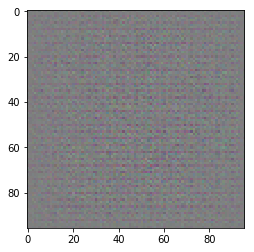

In [42]:
plt.imshow(temp[0])

In [8]:
D.load_state_dict(torch.load("./Dis"))
G.load_state_dict(torch.load("./Gen"))

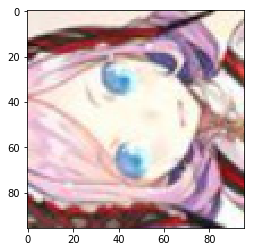

In [13]:
plt.imshow(x.data[0].cpu().numpy().transpose((2,1,0))*.5+.5)

In [49]:
G.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-1.2836e-02,  6.6172e-03,  2.1367e-03, -1.4427e-02],
                        [-1.8411e-02, -4.5778e-03,  2.1960e-02, -1.7218e-02],
                        [ 6.6494e-03,  2.2205e-02, -2.3317e-04,  6.5312e-03],
                        [ 2.2997e-02, -8.7391e-03,  3.8438e-03, -7.1576e-03]],
              
                       [[-1.7704e-02, -1.5518e-02,  1.3657e-02,  1.1492e-02],
                        [ 2.4898e-02,  1.8521e-02, -4.2811e-05, -9.3662e-03],
                        [-4.2917e-03, -1.6377e-02,  1.3757e-02,  2.1213e-02],
                        [-1.9742e-02,  1.3646e-03,  4.2289e-03, -7.2213e-03]],
              
                       [[ 1.7244e-02, -1.7449e-02,  1.8264e-02,  6.3326e-03],
                        [-1.4340e-02,  1.7553e-02,  1.9204e-02, -1.7631e-02],
                        [ 1.2184e-02,  1.1678e-02, -2.2430e-02, -4.3944e-04],
                        [ 7.7234e-03,  2.1745e-02,  2.1877e-02, -2.2838e-02]],
 

In [47]:
G.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-1.2836e-02,  6.6172e-03,  2.1367e-03, -1.4427e-02],
                        [-1.8411e-02, -4.5778e-03,  2.1960e-02, -1.7218e-02],
                        [ 6.6494e-03,  2.2205e-02, -2.3317e-04,  6.5312e-03],
                        [ 2.2997e-02, -8.7391e-03,  3.8438e-03, -7.1576e-03]],
              
                       [[-1.7704e-02, -1.5518e-02,  1.3657e-02,  1.1492e-02],
                        [ 2.4898e-02,  1.8521e-02, -4.2811e-05, -9.3662e-03],
                        [-4.2917e-03, -1.6377e-02,  1.3757e-02,  2.1213e-02],
                        [-1.9742e-02,  1.3646e-03,  4.2289e-03, -7.2213e-03]],
              
                       [[ 1.7244e-02, -1.7449e-02,  1.8264e-02,  6.3326e-03],
                        [-1.4340e-02,  1.7553e-02,  1.9204e-02, -1.7631e-02],
                        [ 1.2184e-02,  1.1678e-02, -2.2430e-02, -4.3944e-04],
                        [ 7.7234e-03,  2.1745e-02,  2.1877e-02, -2.2838e-02]],
 